# IRT Solver - Iterative Refinement - Simulated Data
We assume that each item measures a single scale.

To test our non-parametric IRT model, we generate $20$ items with a parameteric form and sample $200$ student abilities from the prior distribution (normal) assumed in IRT literature. We then use our solver (IRF refinement outer loop for continuation; iterations of updating IRFs using a histogram and MLE estimation of $\theta$ for each IRF resolution).

The process converges to a stationary point, but the resulting IRFs are not smooth.

In [197]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.error
import nirt.irf
import nirt.likelihood
import nirt.mcmc
import nirt.run_recorder
import nirt.simulate.simulate_data
import nirt.simulate.plot_irf
import nirt.solver
import nirt.solver_refinement
import numpy as np
import numpy.matlib
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

# Deterministic results.
numpy.random.seed(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
# Number of persons.
P = 200
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

## Generate Synthetic Data

In [ ]:
# Algorithm parameters.
num_bins = 5
num_iterations = 10
num_theta_sweeps = 5
# Initial simulated annealing temperature.
temperature = 1
# IRF binning strategy.
grid_method = "quantile" # "uniform-fixed" # "quantile" # "uniform" 

In [ ]:
X, theta_exact, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination)
model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
#print("v_exact", v_exact)

In [ ]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
print(theta_exact.shape)
plt.hist(theta_exact[:, 0], 50)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.scatter(range(I), np.sum(X, axis=0)/P, label="Success Prob")
plt.scatter(range(I), b, label="b")
plt.xlabel("Item number $i$")
plt.ylabel("Probability of person success on $X(:,i)$")
plt.legend();

# Initial Guess for $\theta$
Initial guess for $\theta_p^c$: the number of standard deviations person's c's success fraction is away from the mean success fraction of persons in items measuring sub-scale $c$.

When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s.

# Building IRFs from All $\theta$s vs. from Sampled $\theta$
The IRF of item $i$ is a 1D function of $\theta$ in this case. Use a histogram of the currently "active" persons (those being estimated) to build the IRF.

In [ ]:
theta = nirt.likelihood.initial_guess(X, c)
theta = (theta - np.mean(theta, axis=0))/np.std(theta, axis=0)
theta_init = theta

In [ ]:
print("mean", np.mean(theta, axis=0))
print("std", np.std(theta, axis=0))

In [ ]:
# For each dimension, bin ALL persons by theta values into n bins. Binning strategy is either
# quantiles (so all bins have equal sizes) or uniform grid on a fixed domain [-M,M].
inactive = np.arange(P, dtype=int)
active = np.array([], dtype=int)

xlim = [(min(theta[:, ci])-1, max(theta[:, ci])+1) for ci in range(C)]
grid_all = [nirt.grid.create_grid(theta[:, ci], num_bins, method=grid_method, xlim=xlim[ci]) for ci in range(C)]
irf_all = [nirt.irf.ItemResponseFunction(grid_all[ci], X[:, i]) for i, ci in enumerate(c)]
print("Grid limits", xlim)

In [ ]:
# Print the distribution of bin sizes. Should be uniform since it's a quantile grid.
plt.hist(grid_all[0].bin_index, num_bins)
plt.xlabel('bin index')
plt.ylabel('#persons in bin');

In [ ]:
# Generate histogram IRFs from a sample of persons.
initial_sample_per_bin = 10
sample_size = initial_sample_per_bin * num_bins
sample = np.random.choice(inactive, size=sample_size, replace=False)
#sample = np.arange(P, dtype=int)
active = np.concatenate((active, sample))
theta_active = theta[sample]

# Index arrays for converting theta[active] into flattened form and back.
person_ind = np.tile(active[:, None], C).flatten()
c_ind = np.tile(np.arange(C)[None, :], len(active)).flatten()
active_ind = (person_ind, c_ind)

In [ ]:
grid = [nirt.grid.create_grid(theta_active[:, ci], num_bins, method=grid_method, xlim=xlim[ci]) for ci in range(C)]
irf = np.array([nirt.irf.ItemResponseFunction(grid[ci], X[sample, i]) for i, ci in enumerate(c)])
e_all = nirt.error.error_norm_by_item(model_irf, irf_all)
e = nirt.error.error_norm_by_item(model_irf, irf)
print("IRF error of the {} items".format(I))
print("All samples: {:.3f} +- {:.3f}".format(e_all.mean(), e_all.std()))
print("{} samples: {:.3f} +- {:.3f}".format(sample_size, e.mean(), e.std()))

In [ ]:
fig, axs = plt.subplots(I // 4, 4, figsize=(12, 0.8*I))
for i in range(I):
    ax = axs[i // 4, i % 4]
    nirt.simulate.plot_irf.plot_model_irf(ax, grid[c[i]], model_irf[i], num_bins, color="blue", label="Original")
    irf_all[i].plot(ax, color="green", label="{} samples".format(theta.shape[0]))
    irf[i].plot(ax, color="red", label="{} samples".format(sample_size))
    ax.set_title("I {} All {:.2f} Sampled {:.2f}".format(i, e_all[i], e[i]))
    ax.grid(True)

$P_i(\theta)$ is generally monotonically increasing. The discrete approximation to the original synthetic (parametric) form is excellent. 20 persons per bin gives a reasonable approximation.

<!-- # Initial Guess for incoming $\theta$ (upon refinement)
When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s. -->

# Simple Solver: Iterative IRF Refinement + Direct MLE for $\theta$

In the simplest method of iterating between updating IRFs, and improving $\theta$ using the exact MLE, we see convergence only if $\theta$ is normalized to $0$ mean and unit standard deviation, and assuming a normal prior distribution in MLE estimation.

In [235]:
active = np.arange(P, dtype=int)
sample = active
theta_active = theta[sample]

In [236]:
print("mean", np.mean(theta[active], axis=0))
print("std", np.std(theta[active], axis=0))

In [237]:
#v = v_exact
likelihood = nirt.likelihood.Likelihood(X, c, irf)
%time mle = np.array([[likelihood.parameter_mle(p, c, max_iter=5)  for c in range(C)] for p in sample])

In [238]:
# %time mle_localized = np.array([[likelihood.parameter_mle(p, c, max_iter=5, theta_init=theta_active[p][c]) for c in range(C)] for p in sample])

In [239]:
# # Difference between localized and global maximization.
# ind = np.argmax(np.abs(mle_localized-mle))
# #print(mle_localized-mle)
# print(np.where(np.abs(mle_localized-mle) > 1e-10)[0])
# print(ind, mle[ind], mle_localized[ind], theta_active[sample[ind]])

In [240]:
#ind = np.unravel_index(np.argmax(mle, axis=None), mle.shape)
#print(ind, sample[ind[0]], mle.max(), mle[ind])

### Example of Conditional Log Likelihood of a Person
Which we maximize to obtain that person's MLE estimate. It is piecewise convex.

p 85 c 0 MLE estimator: -1.6716913358119678
-1.6716913358119678 -8.669935797627488


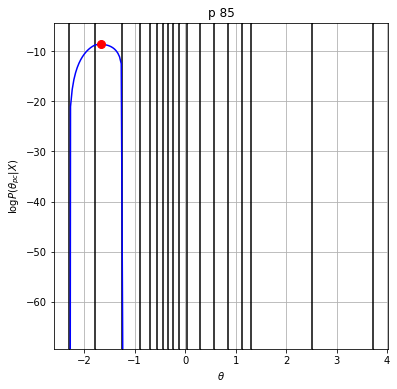

In [244]:
# Check whether the likelihood of a person's theta is concave (has a unique maximum). Verify
# that the MLE is close to the argmax.
dim = 0

persons = [ind] # sample[:3]
fig, axs = plt.subplots(len(persons), 1, figsize=(6, 6))
for k, p in enumerate(persons):
    ax = axs[k] if len(persons) > 1 else axs
    t_mle = likelihood.parameter_mle(p, dim, max_iter=5) 
    print("p {} c {} MLE estimator: {}".format(p, dim, t_mle))
    likelihood.plot_person_log_likelihood(ax, p, dim)
    l_mle = likelihood.log_likelihood_term(np.array([t_mle]), active=(np.array([p]), np.array([dim])))[0]
    print(t_mle, l_mle)
    ax.plot(t_mle, l_mle, 'ro', markersize=8)
    ax.grid(True)
    ax.set_ylim([8 * l_mle, 0.5 * l_mle])
    ax.set_title("p {}".format(p))
    x = likelihood._irf[dim].x
#    print(x)
    L = likelihood.log_likelihood_term(x, active=(np.array([p] * x.size), np.array([dim] * x.size)))
#    print(L)


In [246]:
# tt = np.linspace(-10, 10, 100)
# print("p", p)
# #print("v", v)
# x = X[p]

# def clipped_log(x):
#     return np.log(np.maximum(x, 1e-30))

# L_exact = sum(x[i]*clipped_log(model_irf[i](tt)) 
#               + (1-x[i])*clipped_log(1-model_irf[i](tt)) 
#                 for i in range(I))
# L_approx = sum(x[i]*clipped_log(irf[i].interpolant(tt)) 
#                + (1-x[i])*clipped_log(1-irf[i].interpolant(tt)) 
#                 for i in range(I))
# prior = -tt**2# / v[0]
# L_total = L_exact + prior
# L_total_approx = L_approx + prior

# likelihood = nirt.likelihood.Likelihood(X, c, irf)
# ours = np.array([likelihood._total_likelihood_sum_implementation(ti, p, dim)
#                  for ti in tt])
# print(L_total_approx - ours)
# t_mle = likelihood.parameter_mle(p, dim, max_iter=5)
# l_mle = likelihood.log_likelihood_term(np.array([t_mle]), active=(np.array([p]), np.array([dim])))[0]
# print(t_mle, l_mle)

# #plt.plot(tt, L_exact, label="L_exact")
# #plt.plot(tt, prior, label="prior")
# plt.plot(tt, L_total, label="L_total_exact")
# plt.plot(tt, L_total_approx, label="L_total_approx")
# plt.grid(True)
# plt.ylim([-100, 0])
# #plt.xlim([0, 10])
# print(p, X[p], theta_exact[p], theta_init[p], theta[p])
# print("Exact  {:.3f} {:.3f}".format(tt[L_total.argmax()], max(L_total)))
# print("Approx {:.3f} {:.3f}".format(tt[L_total_approx.argmax()], max(L_total_approx)))

# Itertative Refinement Algorithm
We run the following iterative refinement algorithm: start with 4 bins; IRF resolution is doubled; at each resolution theta is improved to the MLE. Finish when IRF resolution is about
$[P/10]$.

In [231]:
# Run iterative refinement algorithm.
# v is fixed.
recorder = nirt.run_recorder.RunRecorder()
solver = nirt.solver_refinement.SolverRefinement(
    X, c, num_iterations=5, num_theta_sweeps=num_theta_sweeps, grid_method=grid_method,
    recorder=recorder,     finest_resolution=16, coarsest_resolution=4,
num_smoothing_sweeps=0)

t = solver.solve()

INFO     Initial guess range [-2.42, 2.94] mean -0.00 std 1.00
INFO     Solving at IRF resolution 4
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5
INFO     Solving at IRF resolution 8
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5
INFO     Solving at IRF resolution 16
INFO     Iteration 1/5
INFO     Iteration 2/5
INFO     Iteration 3/5
INFO     Iteration 4/5
INFO     Iteration 5/5


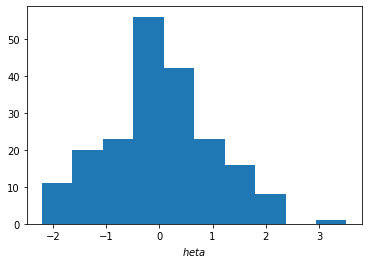

In [232]:
plt.hist(recorder.theta[4][1]);
plt.xlabel("$\theta$");

In [233]:
# Run history: calculate the IRF error from the known parametric model.

for resolution, value in recorder.irf.items():
    logger.info("IRF resolution {}".format(resolution))
    for j in range(len(value)):
        e = nirt.error.error_norm_by_item(model_irf, value[j])
        t = recorder.theta[resolution][j]
        logger.info("IRF error: {:.3f} +- {:.3f}\tt range {:.2f}, {:.2f}".format(
            e.mean(), e.std(), t.min(), t.max()))

INFO     IRF resolution 4
INFO     IRF error: 0.049 +- 0.021	t range -2.30, 3.28
INFO     IRF error: 0.063 +- 0.027	t range -2.20, 3.51
INFO     IRF error: 0.070 +- 0.030	t range -2.15, 3.54
INFO     IRF error: 0.073 +- 0.033	t range -2.13, 3.55
INFO     IRF error: 0.076 +- 0.038	t range -2.09, 3.49
INFO     IRF resolution 8
INFO     IRF error: 0.091 +- 0.048	t range -2.19, 3.75
INFO     IRF error: 0.113 +- 0.050	t range -2.24, 3.70
INFO     IRF error: 0.121 +- 0.055	t range -2.18, 3.71
INFO     IRF error: 0.125 +- 0.056	t range -2.15, 3.71
INFO     IRF error: 0.129 +- 0.055	t range -2.12, 3.68
INFO     IRF resolution 16
INFO     IRF error: 0.158 +- 0.059	t range -2.08, 3.65
INFO     IRF error: 0.174 +- 0.063	t range -2.09, 3.70
INFO     IRF error: 0.177 +- 0.065	t range -2.10, 3.64
INFO     IRF error: 0.177 +- 0.065	t range -2.10, 3.61
INFO     IRF error: 0.177 +- 0.064	t range -2.10, 3.61


[4, 8, 16]


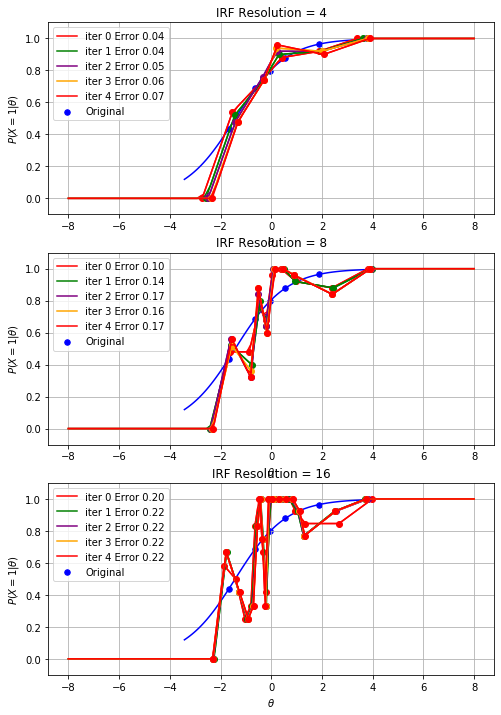

In [247]:
i = 5
resolutions = list(recorder.irf.keys())
print(resolutions)
fig, axs = plt.subplots(len(resolutions), 1, figsize=(8, 4*len(resolutions)))
for k, resolution in enumerate(resolutions):
    ax = axs[k] if len(resolutions) > 1 else axs
    colors = ["red", "green", "purple", "orange"]
    nirt.simulate.plot_irf.plot_model_irf(ax, grid_all[c[i]], model_irf[i], num_bins, color="blue", label="Original")
    for l, irf in enumerate(recorder.irf[resolution]):
        irf[i].plot(ax, color=colors[l % len(colors)],
                    label="iter {} Error {:.2f}".format(
                        l, nirt.error.error_norm(model_irf[i], irf[i])))
    ax.set_title("IRF Resolution = {}".format(resolution))
    ax.grid(True)
    ax.legend()

Even though the initial guess is excellent, already for $n=4$ bins the IRF becomes non-smooth with kinks due to person $\theta$'s moving from one bin to another. We have no regularization on the piecewise linear interpolant IRF. The kinks become worse as the resolution is refined.

Adding several Gauss-Seidel relaxation sweeps on IRF bin values does not help; it smoothes out the profile for coarse resolutions but as the resolution is refined, this is not sufficient to smooth out the kinks. Also, it smears the profile, which is undesirable: some IFs should have a sharp transition from $0$ to $1$. Nonetheless, they don't have kinks.